# Magnus expansion

__Author:__ A. J. Tropiano [tropiano.4@osu.edu]<br/>
__Date:__ January 7, 2020

Generates figures of SRG-evolution in the Magnus expansion formulation, based on this paper: A. J. Tropiano, S. K. Bogner, and R. J. Furnstahl, [Phys. Rev. C __102__, 034005 (2020)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.102.034005).

_Last update:_ June 3, 2022

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

In [2]:
# Imports from A.T. codes
from scripts.figures import (
    set_rc_parameters, line_styles, xkcd_colors, label_channel,
    label_generator, label_kvnn, label_lambda
)
from scripts.magnus import Magnus
from scripts.potentials import Potential
from scripts.tools import find_index, replace_periods

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/magnus/'

## Plotting functions

In [5]:
def potential_slices_srg_only(
        kvnns, channel, kmax, kmid, ntot, generators, lambdas, 
        x_limits=(0.0,3.0), y_limits=(-4.0,4.5), xlabel_size=16,
        ylabel_size=16, channel_label=False, save=False):
    """
    Plots the diagonal and far off-diagonal matrix elements of SRG-evolved
    potentials with respect to k as a multi-column plot. Each column
    corresponds to different \lambda and \Lambda_BD values.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers that specify a set of potentials.
    channel : str
        The partial wave channel (e.g. '1S0').
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    generators : tuple
        SRG generators (e.g., ('Wegner', 'Block-diag')).
    lambdas : tuple
        SRG evolution parameters \lambda and \Lambda_BD [fm^-1]. For block-
        diagonal decoupling, \lambda=1.2 fm^-1.
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [fm].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    channel_label : bool, optional
        Option to add a channel label on the figure as an anchored text.
    save : bool, optional
        Option to save the figure.
    
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = 2
    col_number = len(lambdas)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))
    
    # Set off-diagonal k value depending on channel
    if channel in ('1S0', '3S1'):
        k_od_value = 0
    else:
        k_od_value = 0.5
    
    # --- Get data --- #  
    for i, kvnn in enumerate(kvnns):
        
        # Initialize potential object and get its momentum mesh
        potential = Potential(kvnn, channel, kmax, kmid, ntot)
        k_array, _ = potential.load_mesh()
        
        # Index of off-diagonal k value in k_array
        k_od_index = find_index(k_od_value, k_array)
        
        for j, generator in enumerate(generators):
            
            # Add a sub-plot for each \lambda and \Lambda_BD value
            for k, lamb in enumerate(lambdas):
            
                # Initial potential
                if lamb == np.inf:
                    V_matrix = potential.load_potential()
                # SRG-evolved with block-diagonal generator
                elif generator == 'Block-diag':
                    V_matrix = potential.load_potential('srg', generator, 1.2,
                                                        lamb)
                # SRG-evolved with band-diagonal generators
                else:
                    V_matrix = potential.load_potential('srg', generator,
                                                        lamb)
    
                # If coupled-channel, then plot the lower L-L block
                if potential.coupled_channel_bool:
                    V_matrix = V_matrix[:ntot,:ntot]
                    
                # --- Set data labels --- #
                # Different color for each kvnn
                curve_color = xkcd_colors(i)

                # Different linestyle for each generator
                curve_style = line_styles(j)

                # Label kvnn for Wegner generator only
                if j == 0:
                    kvnn_label = label_kvnn(kvnn)
                else:
                    kvnn_label = ''
                
                # Label generator for first kvnn only
                if i == 0:
                    generator_label = label_generator(generator)
                else:
                    generator_label = ''
                
                # --- Plot --- #
                # Plot diagonal matrix elements on top row and label kvnn
                axs[0, k].plot(
                    k_array, np.diag(V_matrix), color=curve_color,
                    label=kvnn_label, linestyle=curve_style, linewidth=2.0)
                
                # Plot off-diagonal matrix elements on bottom row and label
                # the SRG generator
                axs[1, k].plot(
                    k_array, V_matrix[:, k_od_index], color=curve_color,
                    label=generator_label, linestyle=curve_style,
                    linewidth=2.0)

                # --- Axes limits --- #
                axs[0, k].set_xlim(x_limits)
                axs[0, k].set_ylim(y_limits)
                axs[1, k].set_xlim(x_limits)
                axs[1, k].set_ylim(y_limits)
                    
                # --- Axes labels --- #
                # Label x-axis on bottom row
                axs[1, k].set_xlabel("$k$ [fm" + r"$^{-1}$" + "]",
                                     fontsize=xlabel_size)
                    
    # Label y-axis on left column
    axs[0, 0].set_ylabel(r"$V(k,k)$ [fm]", fontsize=ylabel_size)
    axs[1, 0].set_ylabel(rf"$V(k,{k_od_value})$ [fm]", fontsize=ylabel_size)

    # --- Adjust axes --- #                      
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.05)

    # --- Legends --- #
    # Label kvnns on top row
    axs[0, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                      borderaxespad=0.0, fontsize=18)
    # Label generators on bottom row
    axs[1, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                      borderaxespad=0.0, fontsize=18)

    # --- Additional labels --- #
    # Label partial wave channel in last sub-plot
    if channel_label:
        axs[-1, -1].add_artist(
            AnchoredText(label_channel(channel, label_coupled_channel=False),
                         frameon=False, loc='lower right',
                         prop=dict(size=24))
            )
    
    # Label both \lambda and \Lambda_BD values on each sub-plot
    for irow in range(row_number):
        for i, ilamb in enumerate(lambdas):
            lambda_label = (rf"$\lambda$, $\Lambda_{{\rm{{BD}}}}={ilamb:.1f}$"
                            r" fm$^{-1}$")
            axs[irow, i].add_artist(
                AnchoredText(lambda_label, frameon=False, loc='upper left',
                             prop=dict(size=17))
            )

    # --- Save file --- #
    if save:
        file_name = 'potential_slices_srg_only_kvnns_'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        file_name += f'_{channel}_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}'
        for igenerator in generators:
            file_name += f'_{igenerator}'
        for ilamb in lambdas:
            file_name += f'_{ilamb}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [6]:
def potential_slices_srg_magnus(
        kvnn, channel, kmax, kmid, ntot, generator, lambdas, k_max_values,
        x_limits=(0.0,3.0), y_limits=(-4.5,2.5), xlabel_size=16,
        ylabel_size=16, generator_label=True, kvnn_label=True, save=False):
    """
    Plots the diagonal and far off-diagonal matrix elements of an SRG-evolved
    potential and several Magnus-evolved versions with respect to k as a
    multi-column plot. Each column corresponds to different \lambda or
    \Lambda_BD value.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambdas : tuple
        SRG evolution parameters \lambda [fm^-1]. These values correspond to
        \Lambda_BD with \lambda=1.2 fm^-1 for block-diagonal decoupling.
    x_limits : tuple, optional
        Limits for the x-axis [fm^-1].
    y_limits : tuple, optional
        Limits for the y-axis [fm].
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    generator_label : bool, optional
        Option to add an SRG generator label on one of the sub-plots as an
        anchored text.
    kvnn_label : bool, optional
        Option to add a kvnn label on one of the sub-plots as an anchored
        text.
    save : bool, optional
        Option to save the figure.
    
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = 2
    col_number = len(lambdas)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))
    
    # --- Get data --- #  
    # Initialize potential object and get its momentum mesh
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    k_array, _ = potential.load_mesh()
    
    # Set off-diagonal k value depending on channel
    if channel in ('1S0', '3S1'):
        k_od_value = 0
    else:
        k_od_value = 0.5
    
    # Index of off-diagonal k value in k_array
    k_od_index = find_index(k_od_value, k_array)
        
    # Add a sub-plot for each \lambda or \Lambda_BD value
    for i, lamb in enumerate(lambdas):
        
        # --- Get SRG data --- #
        # SRG-evolved with block-diagonal generator
        if generator == 'Block-diag':
            V_srg_matrix = potential.load_potential('srg', generator, 1.2,
                                                    lamb)
        # SRG-evolved with band-diagonal generators
        else:
            V_srg_matrix = potential.load_potential('srg', generator, lamb)
    
        # If coupled-channel, then plot the lower L-L block
        if potential.coupled_channel_bool:
            V_srg_matrix = V_srg_matrix[:ntot,:ntot]
            
        # --- Plot SRG-evolved potential --- #
        # Plot diagonal matrix elements on top row
        axs[0, i].plot(k_array, np.diag(V_srg_matrix), color='xkcd:black',
                       label='SRG', linestyle='dotted', linewidth=2.0)
                
        # Plot off-diagonal matrix elements on bottom row
        axs[1, i].plot(
            k_array, V_srg_matrix[:, k_od_index], color='xkcd:black',
            label='SRG', linestyle='dotted', linewidth=2.0)
        
        # --- Get Magnus data --- #
        # Set ds = 10^-6 if lambda = 10 fm^-1
        if lamb == 10.0:
            ds = 1e-6
        else:
            ds = 1e-5
            
        for j, k_max in enumerate(k_max_values):
            
            # Magnus-evolved with block-diagonal generator
            if generator == 'Block-diag':
                V_magnus_matrix = potential.load_potential(
                    'magnus', generator, 1.2, lamb, k_max, ds)
            # Magnus-evolved with band-diagonal generators
            else:
                V_magnus_matrix = potential.load_potential(
                    'magnus', generator, lamb, k_max=k_max, ds=ds)
                
            # If coupled-channel, then plot the lower L-L block
            if potential.coupled_channel_bool:
                V_magnus_matrix = V_magnus_matrix[:ntot,:ntot]
                
            # --- Set data labels --- #
            if j == 0:
                curve_color = 'xkcd:blue'
            elif j == 1:
                curve_color = 'xkcd:red'
            else:
                curve_color = 'xkcd:green'
            curve_label = r'$k_{\rm{max}}$' + rf'$={k_max}$'
            curve_style = line_styles(j)
                
            # --- Plot Magnus-evolved potential --- #
            # Plot diagonal matrix elements on top row
            axs[0, i].plot(
                k_array, np.diag(V_magnus_matrix), color=curve_color,
                label=curve_label, linestyle=curve_style, linewidth=2.0)
                
            # Plot off-diagonal matrix elements on bottom row
            axs[1, i].plot(
                k_array, V_magnus_matrix[:, k_od_index], color=curve_color,
                label=curve_label, linestyle=curve_style, linewidth=2.0)
    
        # --- Axes limits --- #
        axs[0, i].set_xlim(x_limits)
        axs[0, i].set_ylim(y_limits)
        axs[1, i].set_xlim(x_limits)
        axs[1, i].set_ylim(y_limits)
                    
        # --- Axes labels --- #
        # Label x-axis on bottom row
        axs[1, i].set_xlabel("$k$ [fm" + r"$^{-1}$" + "]",
                             fontsize=xlabel_size)
                    
    # Label y-axis on left column
    axs[0, 0].set_ylabel(r"$V(k,k)$ [fm]", fontsize=ylabel_size)
    axs[1, 0].set_ylabel(rf"$V(k,{k_od_value})$ [fm]", fontsize=ylabel_size)

    # --- Adjust axes --- #                      
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.05)

    # --- Legends --- #
    # Label k_max values on lower left sub-plot
    axs[1, 0].legend(loc='upper left', fontsize=18, frameon=False)

    # --- Additional labels --- #
    # Label generator in last sub-plot
    if generator_label:
        axs[-1, -1].add_artist(
            AnchoredText(label_generator(generator), frameon=False,
                         loc='lower right', prop=dict(size=22))
            )
        
    # Label kvnn in first sub-plot
    if kvnn_label:
        axs[0, 0].add_artist(
            AnchoredText(label_kvnn(kvnn), frameon=False, loc='center left',
                         prop=dict(size=22))
            )
    
    # Label \lambda or \Lambda_BD values on each sub-plot in the top row
    for i, ilamb in enumerate(lambdas):
        lambda_label = label_lambda(ilamb, generator)
        axs[0, i].add_artist(
            AnchoredText(lambda_label, frameon=False, loc='upper left',
                         prop=dict(size=19))
            )

    # --- Save file --- #
    if save:
        file_name = (f'potential_slices_srg_magnus_kvnn_{kvnn}_{channel}'
                     f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}')
        for ilamb in lambdas:
            file_name += f'_{ilamb}'
        file_name += '_k_max_values'
        for ik_max in k_max_values:
            file_name += f'_{ik_max}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [7]:
def generate_norms(kvnn, channel, kmax, kmid, ntot, generator, k_max, ds,
                   s_final=0.904):
    """
    Computes and saves the Frobenius norms of \eta and \Omega with respect to
    s for a Magnus-evolved potential.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    k_max : int
        d\Omega(s)/ds sum from 0 to k_max.
    ds : float
        Step-size in the flow parameter s [fm^4].
    s_final : float, optional
        Final s value in the Magnus-evolution [fm^4].
    
    Returns
    -------
    s_array : 1-D ndarray
        Array of s values [fm^4].
    eta_norms_array : 1-D ndarray
        Array of ||\eta(s)|| [fm^-4].
    O_norms_array : 1-D ndarray
        Array of ||\Omega(s)|| [unitless].
    
    """
    
    # Set-up array of linearly-spaced s values [fm^4]
    s_array = np.arange(0.0, s_final, ds)
    
    magnus = Magnus(kvnn, channel, kmax, kmid, ntot, generator)
    
    # Magnus-evolve the potential and get the matrix norms of \eta and \Omega
    t0 = time.time()
    s_array, eta_norms_array, O_norms_array = magnus.get_norms(s_array,
                                                               k_max=6)
    t1 = time.time()
    hours = (t1-t0)/3600
    print(f"Done evolving kvnn {kvnn} after {hours:.2f} hours.")
    
    # Combine data into one array
    data = np.asarray((s_array, eta_norms_array, O_norms_array)).T
    
    # Save matrix norms in the directory of the potential
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    data_directory = potential.potential_directory
    
    file_name = (f'magnus_matrix_norms_{channel}_kvnn_{kvnn}_{generator}'
                 f'_s_final_{s_final}_k_max_{k_max:d}_ds_{ds:.1e}.out')
    
    # Save using NumPy's savetxt function
    header = "{:<10s}\t{:<20s}\t{:<20s}".format(
        "s [fm^4]", "||\eta(s)|| [fm^-4]", "||\Omega(s)||")
    np.savetxt(data_directory + file_name, data,
               fmt=('%-20e', '%-20e', '%-20e'), delimiter='\t', header=header)
    
    return s_array, eta_norms_array, O_norms_array

In [8]:
def magnus_matrix_norms(
        kvnns, channel, kmax, kmid, ntot, generator, k_max=6, s_final=0.904,
        generate_data=False, s_limits=(1e-5,0.904), eta_limits=(1e0,1e7),
        O_limits=(1e-3,1e4), xlabel_size=16, ylabel_size=16, save=False):
    """
    Plots the Frobenius norms of \eta and \Omega with respect to s for several
    Magnus-evolved potentials.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers that specify a set of potentials.
    channel : str
        The partial wave channel (e.g. '1S0').
    kmax : float
        Maximum value in the momentum mesh [fm^-1].
    kmid : float
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    k_max : int, optional
        d\Omega(s)/ds sum from 0 to k_max.
    s_final : float, optional
        Final s value in the Magnus-evolution [fm^4].
    generate_data : bool, optional
        Option to generate the data files instead of loading files.
    s_limits : tuple, optional
        Limits in s for the x-axis [fm^4].
    eta_limits : tuple, optional
        Limits in ||\eta(s)|| for the y-axis of the first sub-plot [fm^-4].
    O_limits : tuple, optional
        Limits in ||\Omega(s)|| for the y-axis of the second sub-plot.
    xlabel_size : int, optional
        Fontsize for the x-axis label.
    ylabel_size : int, optional
        Fontsize for the y-axis label.
    save : bool, optional
        Option to save the figure.
    
    """
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = 1
    col_number = 2
    f, axs = plt.subplots(row_number, col_number,
                          figsize=(4*col_number,4*row_number))

    # --- Get data --- #
    for i, kvnn in enumerate(kvnns):
        
        # Set step-size
        if kvnn == 901:
            ds = 1e-6  # Needed a finer step-size to get this one to work
        else:
            ds = 1e-5
            
        # Generate the data files
        if generate_data:
            
            s_array, eta_norms_array, O_norms_array = generate_norms(
                kvnn, channel, kmax, kmid, ntot, generator, k_max, ds)
        
        # Load existing data files
        else:
            
            # Matrix norms are in the potential's directory
            potential = Potential(kvnn, channel, kmax, kmid, ntot)
            data_directory = potential.potential_directory
    
            file_name = (f'magnus_matrix_norms_{channel}_kvnn_{kvnn}'
                         f'_{generator}_s_final_{s_final}_k_max_{k_max:d}'
                         f'_ds_{ds:.1e}.out')
            
            data = np.loadtxt(data_directory + file_name)
            
            s_array, eta_norms_array, O_norms_array = data.T

        # --- Set data labels --- #
        if i == 0:
            curve_style = 'dashed'
        elif i == 1:
            curve_style = 'dashdot'
        else:
            curve_style = 'solid'
        curve_color = xkcd_colors(i)
        kvnn_label = label_kvnn(kvnn)

        # --- Plot --- #
        # Plot ||\eta(s)|| on the first sub-plot
        axs[0].loglog(s_array, eta_norms_array, color=curve_color,
                      label=kvnn_label, linestyle=curve_style, linewidth=2.0)
        
        # Plot ||\Omega(s)|| on the second sub-plot
        axs[1].loglog(s_array, O_norms_array, color=curve_color,
                      label=kvnn_label, linestyle=curve_style, linewidth=2.0)
                
    # --- Axes limits --- #
    axs[0].set_xlim(s_limits)
    axs[0].set_ylim(eta_limits)
    axs[1].set_xlim(s_limits)
    axs[1].set_ylim(O_limits)
                    
    # --- Axes labels --- #
    # Same x-axis on both
    axs[0].set_xlabel("$s$ [fm" + r"$^{4}$" + "]", fontsize=xlabel_size)
    axs[1].set_xlabel("$s$ [fm" + r"$^{4}$" + "]", fontsize=xlabel_size)
                    
    # Label y-axes
    axs[0].set_ylabel(r"$||\eta(s)||$ [fm" + r"$^{-4}$" + "]",
                      fontsize=ylabel_size)
    axs[1].set_ylabel(r"$||\Omega(s)||$", fontsize=ylabel_size)

    # --- Adjust axes --- #                      
    # Prevent first sub-plot from covering up second sub-plot's ylabel
    f.tight_layout()

    # --- Legend --- #
    axs[0].legend(loc='upper right', fontsize=16, frameon=False)
    axs[1].legend(loc='upper right', fontsize=16, frameon=False)

    # --- Save file --- #
    if save:
        file_name = 'magnus_matrix_norms_kvnns_'
        for ikvnn in kvnns:
            file_name += f'_{ikvnn}'
        file_name += (f'_{channel}_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_'
                      f'{generator}_k_max_{k_max}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

## Matrix elements of SRG-evolved high cutoff potentials

Nonlocal leading-order potentials at cutoffs of $4$, $9$, and $20$ fm$^{-1}$ in the $^{3}{\rm S}_1$ channel. We compare SRG evolution using the Wegner generator $G=H_{\rm{D}}$ and the block-diagonal generator $G=H_{\rm{BD}}$. Each column shows a different set of $\lambda$ and $\Lambda_{\rm{BD}}$ values. The top row shows the diagonal matrix elements, and the bottom row shows far off-diagonal matrix elements.

In [9]:
kvnns = (900, 901, 902)
channel = '3S1'
kmax, kmid, ntot = 30.0, 4.0, 120
generators = ('Wegner', 'Block-diag')
lambdas = (10.0, 2.8, 2.0, 1.2)

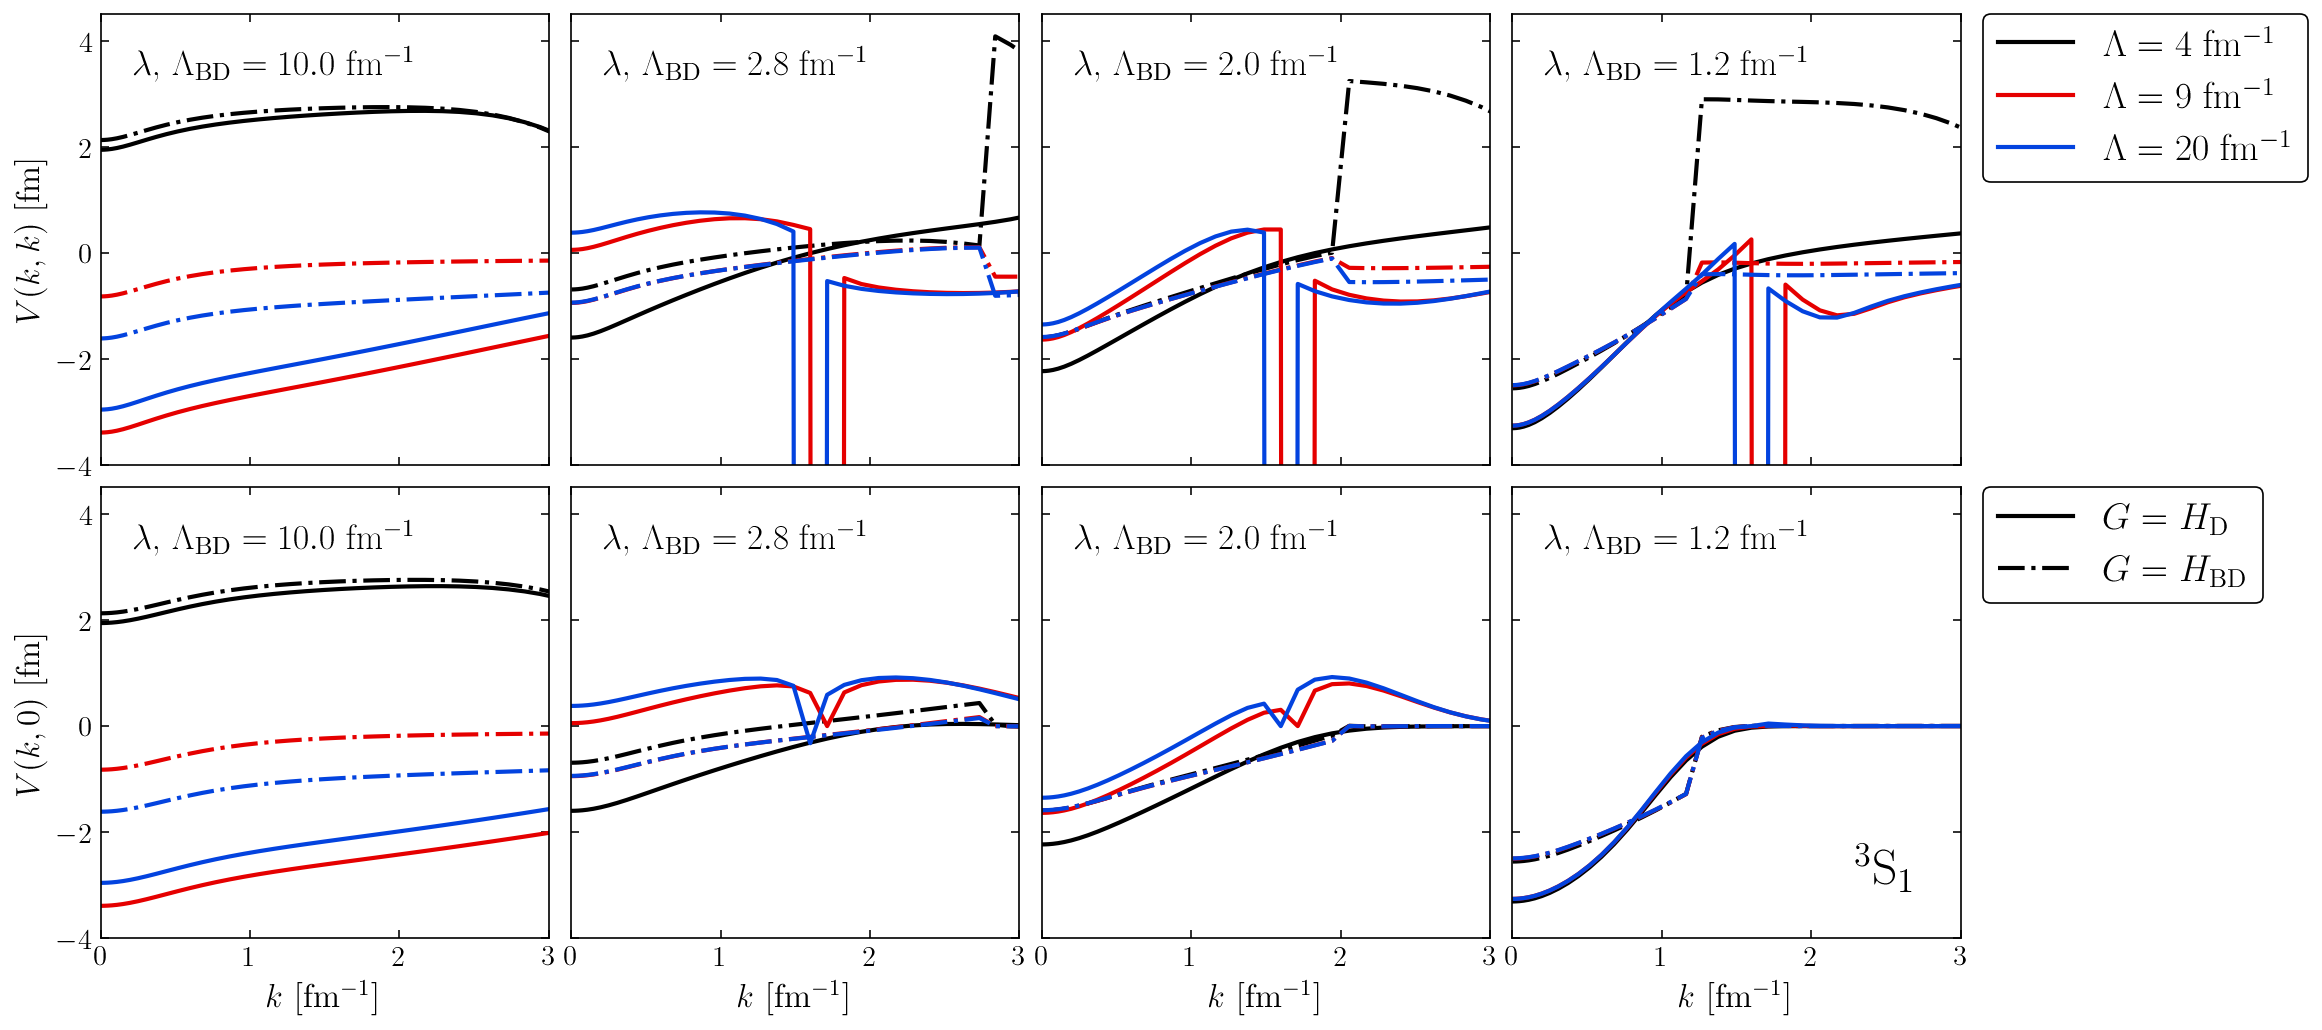

In [10]:
potential_slices_srg_only(kvnns, channel, kmax, kmid, ntot, generators,
                          lambdas, channel_label=True, save=True)

## Comparison of Magnus- and SRG-evolved potentials

Using the $\Lambda=9$ fm$^{-1}$ potential in the $^{3}{\rm S}_1$ channel from above, we compare SRG evolution to several Magnus evolutions, varying $k_{\rm{max}}$. Here we take $G=H_{\rm{D}}$. As before, each column corresponds to different $\lambda$ values, the top row to diagonal matrix elements, and the bottom row to far off-diagonal matrix elements.

In [11]:
kvnn = 901
channel = '3S1'
kmax, kmid, ntot = 30.0, 4.0, 120
lambdas = (10.0, 2.8, 2.0, 1.2)
k_max_values = (2, 6, 10)

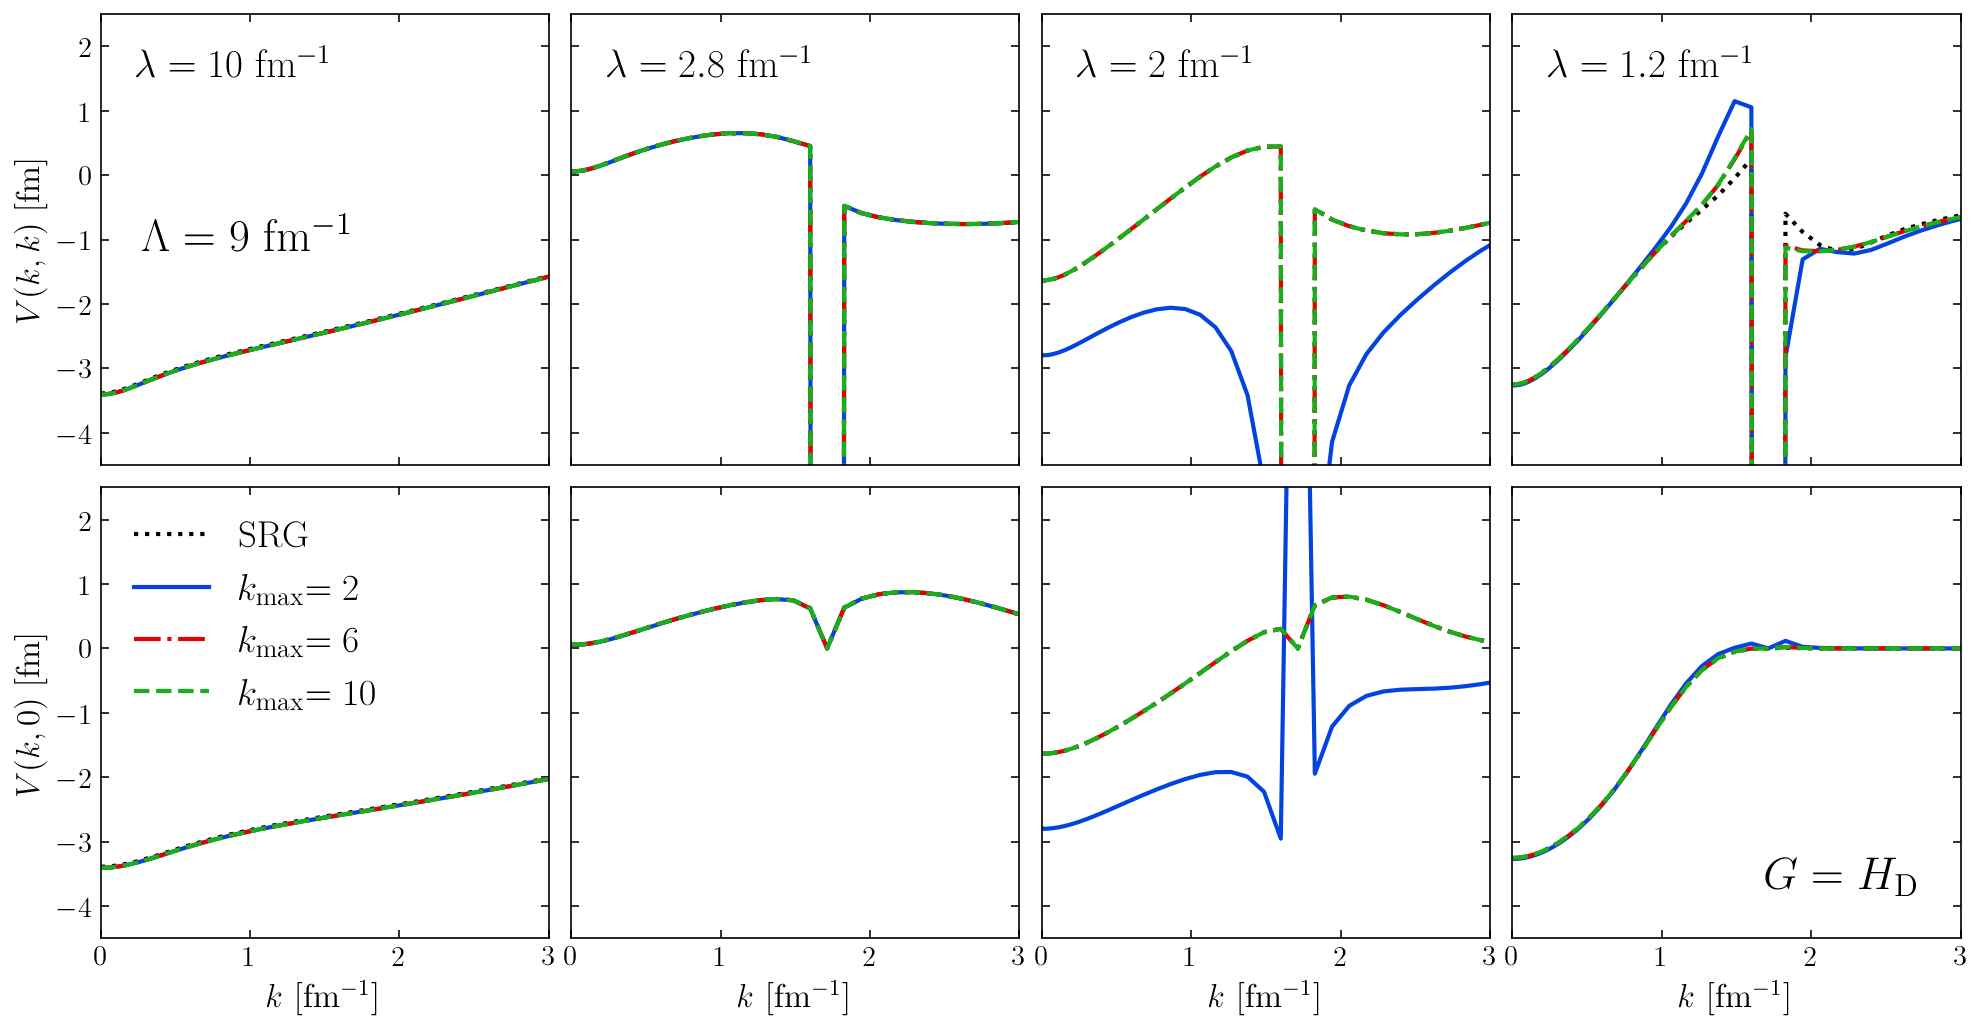

In [12]:
potential_slices_srg_magnus(kvnn, channel, kmax, kmid, ntot, 'Wegner',
                            lambdas, k_max_values, save=True)

Same case as above but with the relative kinetic energy generator $G=T_{\rm{rel}}$.

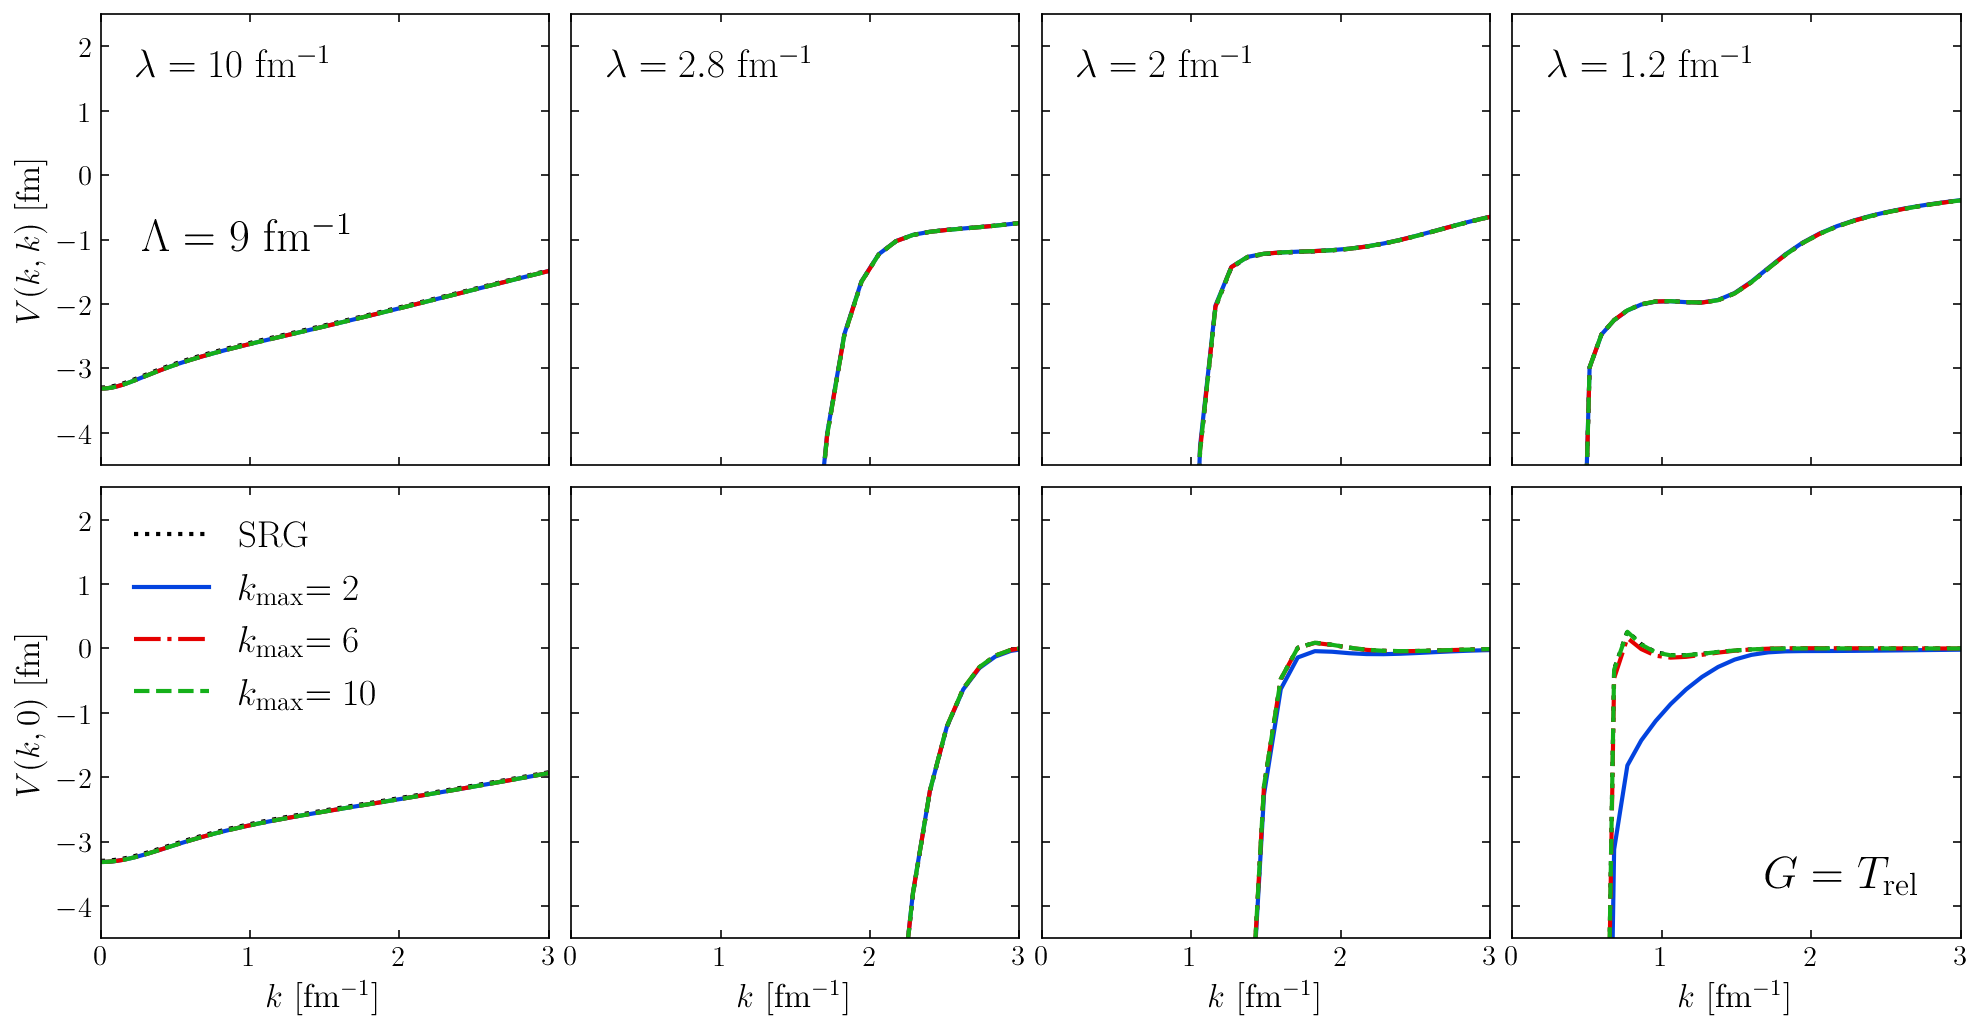

In [13]:
potential_slices_srg_magnus(kvnn, channel, kmax, kmid, ntot, 'T', lambdas,
                            k_max_values, save=True)

## Testing convergence in the Magnus formulation

Convergence of the Magnus expansion can be described in terms of the Frobenius norm of $\eta(s)$. Here we show the Frobenius norms of $\eta(s)$ and $\Omega(s)$ with respect to $s$ for all three high cutoff potentials from before. We take $G=H_{\rm{D}}$ and evolve in the $^{3}{\rm S}_1$-$^{3}{\rm D}_1$ channel.

In [14]:
kvnns = (900, 901, 902)
channel = '3S1'
kmax, kmid, ntot = 30.0, 4.0, 120
generator = 'Wegner'

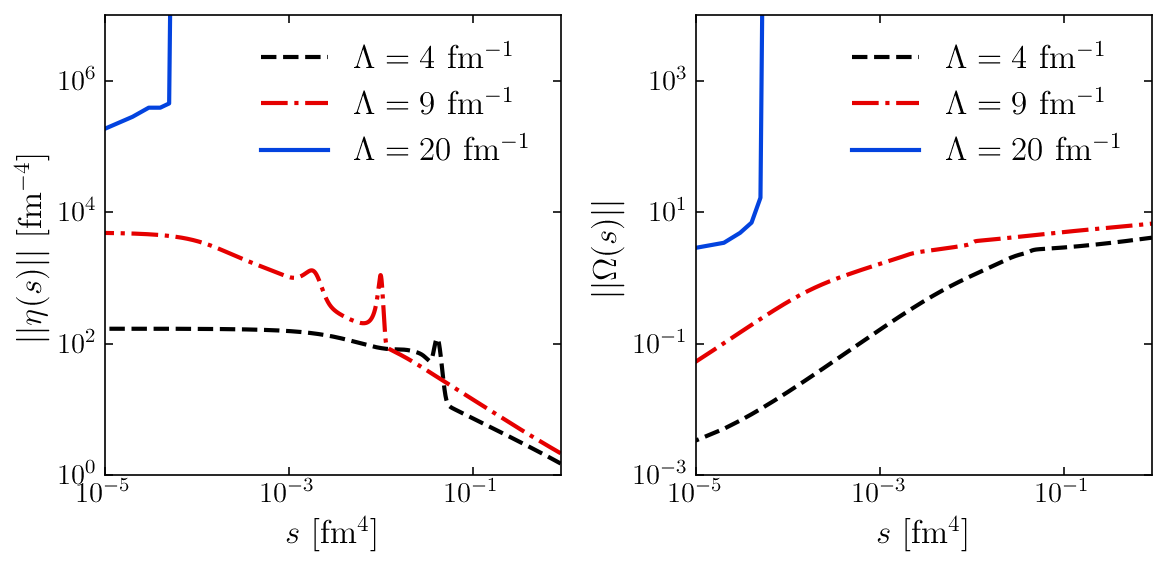

In [15]:
magnus_matrix_norms(kvnns, channel, kmax, kmid, ntot, generator, save=True)